# Imports

In [1]:
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from skimage.util import invert
import skimage as ski
from skimage.util import img_as_ubyte
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from torchsummary import summary

# Model Architecture

## Unet

In [56]:
class DoubleConv(nn.Module):
    def __init__ (self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [57]:
class Unet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 2, features = [64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride = 2))
            self.ups.append(DoubleConv(feature*2, feature))


        self.bottom = DoubleConv(features[-1], features[-1]*2)
        self.last = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        sc = []

        for down in self.downs:
            x = down(x)
            sc.append(x)
            x = self.pool(x)

        x = self.bottom(x)
        sc = sc[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = sc[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.last(x)



## Residual Unet

In [3]:
class ResDoubleConv(nn.Module):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False)
		self.b1 = nn.BatchNorm2d(out_channels)
		self.r1 = nn.ReLU(inplace=True)
		self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
		self.b2 = nn.BatchNorm2d(out_channels)
		self.r2 = nn.ReLU(inplace=True)
		self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) if in_channels != out_channels else nn.Identity()


	def forward(self, x):
		res = self.residual_conv(x)
		x = self.conv1(x)
		x = self.b1(x)
		x = self.r1(x)
		x = self.conv2(x)
		x = self.b2(x)
		x += res
		x = self.r1(x)
		return x

In [4]:

class ResUnet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 2, features = [64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        for feature in features:
            self.downs.append(ResDoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride = 2))
            self.ups.append(ResDoubleConv(feature*2, feature))


        self.bottom = ResDoubleConv(features[-1], features[-1]*2)
        self.last = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        sc = []

        for down in self.downs:
            x = down(x)
            sc.append(x)
            x = self.pool(x)

        x = self.bottom(x)
        sc = sc[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = sc[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.last(x)



### Model test

In [5]:
x = torch.rand((3,1,512,512))
model = ResUnet(in_channels=1, out_channels=1)
preds = model(x)
print(preds.shape)
print(x.shape)

torch.Size([3, 1, 512, 512])
torch.Size([3, 1, 512, 512])


# Data processing

In [6]:
data_dir = './db/unet_1'

## Skeletonization test

In [ ]:
files = os.listdir(data_dir+'/img')

In [ ]:
files[0]

'nj_124_2_LCA_RAO.png'

In [ ]:
def readImages(dir):
    img_file = os.listdir(data_dir+'/img')
    label_file = os.listdir(data_dir+'/label')
    list = [ [], [] ]
    for img, label in zip(img_file, label_file):
        list[0].append(ski.io.imread(dir+'/img/'+img))
        list[1].append(ski.io.imread(dir+'/label/'+label))
    return list[0], list[1]

In [ ]:
img, label = readImages(data_dir)

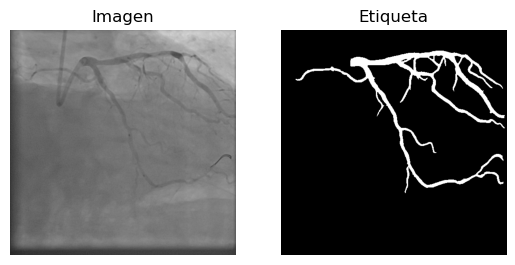

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Imagen')
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Etiqueta')
plt.imshow(label[0], cmap="gray")
plt.axis('off')

plt.show()

In [ ]:
gray_image = ski.color.rgb2gray(label[0])

In [ ]:
skeleton = skeletonize(gray_image)

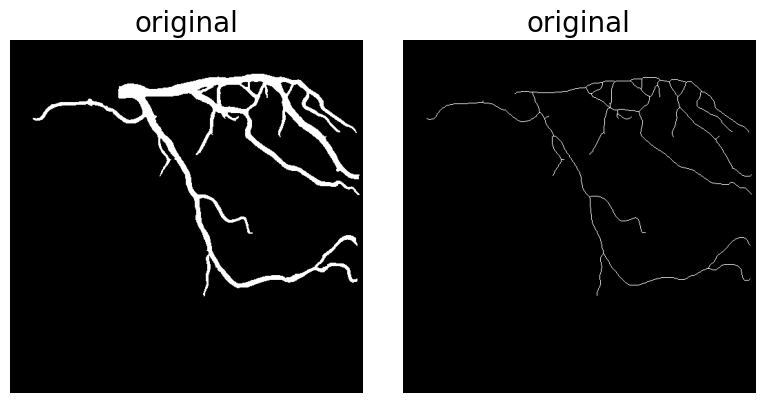

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(label[0], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('original', fontsize=20)

fig.tight_layout()
plt.show()

## Label skeletonization

In [ ]:
input_dir = os.path.join(data_dir,'label')
output_dir = os.path.join(data_dir, 'label_skeleton')

In [ ]:
labels = os.listdir(input_dir)

In [ ]:
os.makedirs(output_dir, exist_ok=True)

In [ ]:
for label in labels:

    input_image_path = os.path.join(input_dir, label)
    output_image_path = os.path.join(output_dir, label)
    image = ski.io.imread(input_image_path)

    if image.dtype == 'bool':
        image = img_as_ubyte(image)

    if image.ndim == 3 and image.shape[2] == 3:
        image = ski.color.rgb2gray(image)

    image = skeletonize(image)

    image = ski.img_as_ubyte(image)
    ski.io.imsave(output_image_path, image)

In [ ]:
total = len(labels)
final = len(os.listdir(output_dir))
print(100 * (final/total))
print(final)
print(total)

85.55194805194806
527
616


## Dataset class

In [8]:
class UnetDataset(Dataset):

    def __init__(self, img_dir, label_dir, names , transform=None, label_transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.names = names
        self.transform = transform
        self.label_transform=label_transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.names[idx])
        label_path = os.path.join(self.label_dir, self.names[idx])
        image = Image.open(img_path).convert("RGB")
        label = np.array(Image.open(label_path).convert("L"), dtype=np.float32)
        label[label == 255.0] = 1.0
        label = Image.fromarray(label)


        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)


        return image, label

## Data split

In [9]:
data_dir = './drive/MyDrive/unet'

In [10]:
names = os.listdir(data_dir+'/label_skeleton')

In [11]:
img_dir = os.path.join(data_dir, 'img')
label_dir = os.path.join(data_dir, 'label_skeleton')

In [32]:
X_train, X_test = train_test_split(names, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=len(X_test), random_state=42)

In [33]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

420
53
53


In [34]:
img_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    ToTensor(),
])

label_transform = transforms.Compose([
	transforms.Resize(224),
	transforms.CenterCrop(224),
	ToTensor(),
])

In [35]:
train_dataset = UnetDataset(img_dir, label_dir, X_train, transform=img_transforms, label_transform=label_transform)
test_dataset = UnetDataset(img_dir, label_dir, X_test, transform = img_transforms, label_transform=label_transform)
val_dataset = UnetDataset(img_dir, label_dir, X_val, transform = img_transforms, label_transform=label_transform)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [37]:
img1, label1 = train_dataset[0]

In [38]:
img1

tensor([[[0.3647, 0.3922, 0.4078,  ..., 0.4510, 0.3765, 0.3412],
         [0.3725, 0.4078, 0.4235,  ..., 0.4941, 0.4039, 0.3373],
         [0.3686, 0.4078, 0.4314,  ..., 0.5333, 0.4275, 0.3333],
         ...,
         [0.1765, 0.1765, 0.1725,  ..., 0.3020, 0.2980, 0.2941],
         [0.1765, 0.1725, 0.1765,  ..., 0.3020, 0.2980, 0.2941],
         [0.1804, 0.1725, 0.1765,  ..., 0.2980, 0.2902, 0.2980]],

        [[0.3647, 0.3922, 0.4078,  ..., 0.4510, 0.3765, 0.3412],
         [0.3725, 0.4078, 0.4235,  ..., 0.4941, 0.4039, 0.3373],
         [0.3686, 0.4078, 0.4314,  ..., 0.5333, 0.4275, 0.3333],
         ...,
         [0.1765, 0.1765, 0.1725,  ..., 0.3020, 0.2980, 0.2941],
         [0.1765, 0.1725, 0.1765,  ..., 0.3020, 0.2980, 0.2941],
         [0.1804, 0.1725, 0.1765,  ..., 0.2980, 0.2902, 0.2980]],

        [[0.3647, 0.3922, 0.4078,  ..., 0.4510, 0.3765, 0.3412],
         [0.3725, 0.4078, 0.4235,  ..., 0.4941, 0.4039, 0.3373],
         [0.3686, 0.4078, 0.4314,  ..., 0.5333, 0.4275, 0.

In [39]:
img1.shape

torch.Size([3, 224, 224])

In [40]:
label1

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [41]:
label1.shape

torch.Size([1, 224, 224])

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Imagen')
plt.imshow(img1.permute(1,2,0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Etiqueta')
plt.imshow(label1.permute(1,2,0), cmap="gray")
plt.axis('off')

plt.show()

# Metrics functions


- Accuracy
- F1 score
- Coeficinete dice
- Recall
- Presición

In [ ]:
def check_metrics(model, loader, criterion, device):
    dice_score = 0.0
    num_correct = 0.0
    num_pixels = 0.0
    true_positives = 0.0
    false_positives = 0.0
    false_negatives = 0.0
    loss = 0.0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            
            num_correct += (preds == y).sum().float()
            
            true_positives += ( (preds == y ) & ( y == 1.0) ).sum().float()
            false_positives += ( (preds == 1.0) & ( y == 0.0 ) ).sum().float()
            false_negatives += ( ( preds == 0.0 ) & ( y == 1.0) ).sum().float()

            num_pixels += torch.numel(preds)
            
            
            intersection = (preds * y).sum().float()
            union = (preds + y).sum().float()
            dice_score += (2. * intersection) / (union + 1e-8)

            val_loss = criterion(preds, y)
            loss += val_loss.item()
    
    
    accuracy = num_correct / num_pixels    
    precision = true_positives / ( true_positives + false_positives )
    recall = true_positives / ( true_positives + false_negatives )
    f1_score = ( 2 * precision * recall ) / (precision + recall )
    dice_score /= len(loader)
    loss /= len(loader)

    return [loss.item(), accuracy.item(), precision.item(), recall.item(), f1_score.item(), dice_score.item()]

# Trainig function

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device, save):
    
    train_losses = []
    val_losses = []
    accuracy = []
    precision = []
    recall = []
    f1_score = []
    dice_score = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.float().to(device)
            y_train = y_train.float().to(device)

            # Forward pass
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        t_len = len(train_loader)
        train_losses.append(train_loss / t_len)

        metrics = check_metrics(model, val_loader, criterion, device)

        val_losses.append(metrics[0])
        accuracy.append(metrics[1])
        precision.append(metrics[2])
        recall.append(metrics[3])
        f1_score.append(metrics[4])
        dice_score.append(metrics[5])

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {metrics[0]:.4f} | "
              f"Accuracy: {metrics[1]:.4f} | Precision: {metrics[2]:.4f} | Recall: {metrics[3]:.4f} | "
              f"F1 Score: {metrics[4]:.4f} | Dice Score: {metrics[5]:.4f}")
    
    results = pd.DataFrame({
        'Epoch': list(range(1, epochs + 1)),
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Dice Score': dice_score
    })
    save_name = f"{save}_training_results.csv"
    results.to_csv(save_name, index=False)
    
    return resutls

# Model Training

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
unet = Unet(in_channels=3, out_channels=1).to(device)

In [44]:
resunet = ResUnet(in_channels=3, out_channels=1).to(device)

In [45]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [46]:
epochs = 25

In [ ]:
results = train(unet, criterion, optimizer, train_loader, val_loader, epochs, device, "unet")

In [ ]:
results = train(unet, criterion, optimizer, train_loader, val_loader, epochs, device, "resunet")

## Testing

In [ ]:
metrics = check_metrics(unet, test_loader, criterion, device)
save_name = "unet_test_results.csv"
print(f"Accuracy: {metrics[1]:.4f} | Precision: {metrics[2]:.4f} | Recall: {metrics[3]:.4f} | "
        f"F1 Score: {metrics[4]:.4f} | Dice Score: {metrics[5]:.4f}")

In [ ]:
metrics = check_metrics(resunet, test_loader, criterion, device)
save_name = "resunet_test_results.csv"
print(f"Accuracy: {metrics[1]:.4f} | Precision: {metrics[2]:.4f} | Recall: {metrics[3]:.4f} | "
        f"F1 Score: {metrics[4]:.4f} | Dice Score: {metrics[5]:.4f}")

In [ ]:
df_metrics = pd.DataFrame([metrics], columns=['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Dice Score'])

In [ ]:
results.to_csv(save_name, index=False)

## Save

In [49]:
torch.save(unet.state_dict(), './drive/MyDrive/Model/unet_dict.pth')
torch.save(unet, './drive/MyDrive/Model/unet.pth')

In [ ]:
torch.save(resunet.state_dict(), './drive/MyDrive/Model/resunet_dict.pth')
torch.save(resunet, './drive/MyDrive/Model/resunet.pth')

# Evaluation

### Train

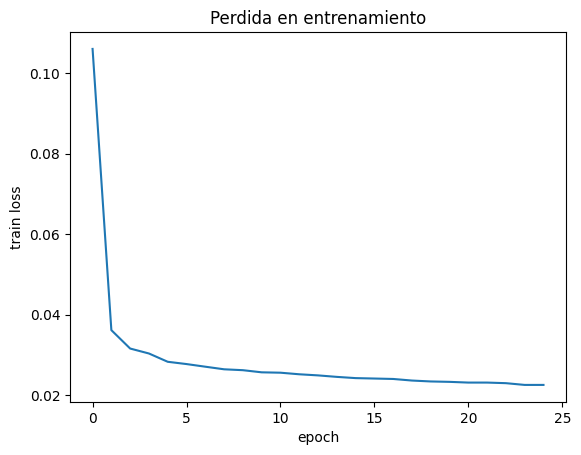

In [50]:
plt.figure()
plt.plot(np.array(train_losses))
plt.title('Perdida en entrenamiento')
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

### Validation

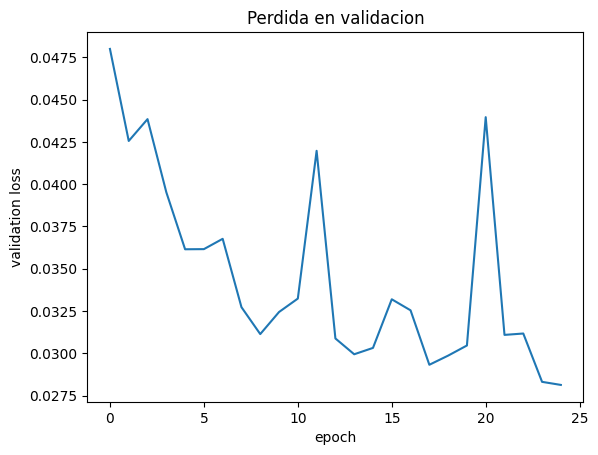

In [51]:
plt.figure()
plt.plot(np.array(val_losses))
plt.title('Perdida en validacion')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.show()

### Train vs Val

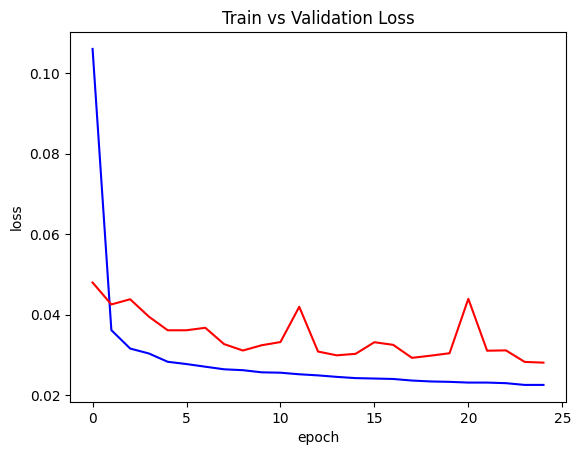

In [53]:
plt.figure()
plt.plot(np.array(train_losses), color="blue")
plt.plot(np.array(val_losses), color="red")
plt.title('Train vs Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Model testing

In [67]:
model_unet = Unet(in_channels=3, out_channels=1).to(device)
model_unet.load_state_dict(torch.load('./drive/MyDrive/Model/unet_dict.pth'))

<All keys matched successfully>

In [68]:
model = ResUnet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load('./drive/MyDrive/Model/resunet_dict_chk2.pth'))

<All keys matched successfully>

In [69]:
img_test, label_test = train_dataset[10]
img_test = img_test.to(device)
label_test = label_test.to(device)

with torch.no_grad():
    y_pred = model(img_test.unsqueeze(0))
    y_pred = torch.sigmoid(y_pred)
    y_pred2 = model_unet(img_test.unsqueeze(0))
    y_pred2 = torch.sigmoid(y_pred2)

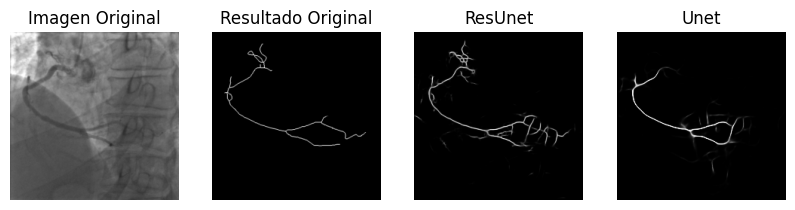

In [70]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

axes[0].imshow(img_test.cpu().detach().numpy().transpose(1, 2, 0))
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(label_test.cpu().detach().numpy().squeeze(), cmap="gray")
axes[1].set_title('Resultado Original')
axes[1].axis('off')

axes[2].imshow(y_pred.cpu().detach().numpy().squeeze(), cmap="gray")
axes[2].set_title('ResUnet')
axes[2].axis('off')

axes[3].imshow(y_pred2.cpu().detach().numpy().squeeze(), cmap="gray")
axes[3].set_title('Unet')
axes[3].axis('off')

plt.show()

## Extra

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)

        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    t_len = len(train_loader)
    train_losses.append(train_loss / t_len)

    model.eval()
    val_loss = 0

    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):

            X_val = X_val.float().to(device)
            y_val = y_val.float().to(device)

            # Forward pass
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

    v_len = len(val_loader)
    val_losses.append(val_loss / v_len)

    print(f"Epoch {epoch+1} "
          f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, ")

- Binary cross entropy loss function

In [ ]:
def ce(y, y_i):
    ep = 1e-8
    part1 = y_i * np.log(y+ep)
    part2 = (1 - y_i)*np.log(1-y+ep)
    return np.mean(-(part1+part2))

In [ ]:
y = np.linspace(0,1, 10)
y_i = np.zeros(10)
y_i2 = np.ones(10)

r1 = ce(y, y_i)
r2 = ce(y, y_i2)

In [ ]:
x = np.linspace(0,1,9).reshape(3,3)

In [ ]:
x

array([[0.   , 0.125, 0.25 ],
       [0.375, 0.5  , 0.625],
       [0.75 , 0.875, 1.   ]])

In [ ]:
y_1 = np.ones(9).reshape(3,3)

In [ ]:
y_0 = np.zeros(9).reshape(3,3)

In [ ]:
ce(x, y_1)

2.7168455508019154

In [ ]:
r1

2.5393874205289735

In [ ]:
r2

2.539387420528974

In [ ]:
r1

array([       nan, 0.11778304, 0.25131443, 0.40546511, 0.58778666,
       0.81093022, 1.09861229, 1.5040774 , 2.19722458,        inf])

In [ ]:
r2

array([       inf, 2.19722458, 1.5040774 , 1.09861229, 0.81093022,
       0.58778666, 0.40546511, 0.25131443, 0.11778304,        nan])

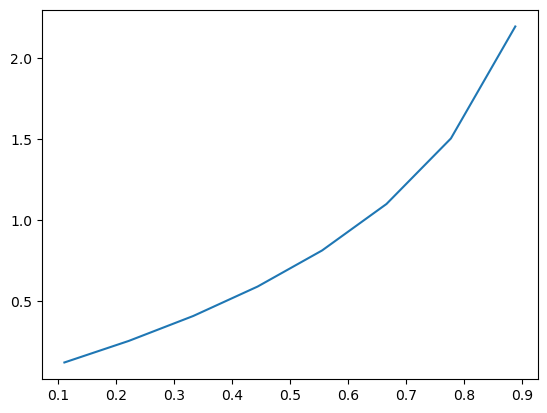

In [ ]:
plt.plot(y, r1)

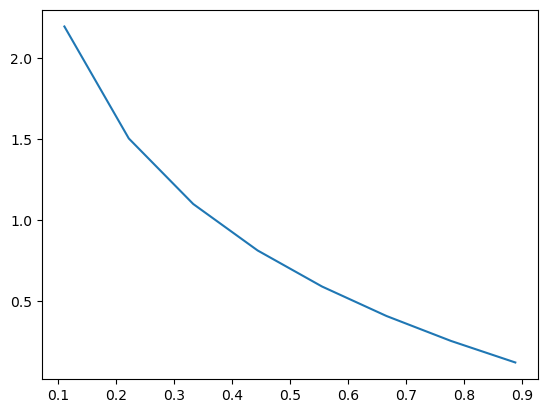

In [ ]:
plt.plot(y, r2)

In [ ]:
loss = nn.BCELoss()